In [1]:
import numpy as np
# from tqdm import tqdm, trange
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import numba
from numba import prange
from time import perf_counter
from scipy.ndimage import convolve, sobel
from scipy import ndimage
from sklearn import preprocessing
from scipy.stats import mode
import seaborn as sns

from scipy.stats import gaussian_kde
from scipy.integrate import quad

from npfi import npfi, get_pdfs_from_data
# import statistics as statss
%matplotlib inline
sns.set_style("ticks")
sns.set_context("poster")

def timer(method):
    def timed(*args, **kw):
        ts = perf_counter()
        result = method(*args, **kw)
        te = perf_counter()
        tlapsed = te-ts
        print(f"{tlapsed//60} mins and {tlapsed%60:0.2f} secs")
        return result
    return timed

# def grierer_meinhardt(U, V, Du, Dv, c1, c2, c3, c4, c5, k, dt, dx, T, sr=5):
#     n = U.shape[0]
#     iters = int(T / dt)
#     for i in tqdm(range(iters)):
#         Lu = Du*lap_neumann(U)/dx/dx
#         Lv = Dv*lap_neumann(V)/dx/dx
#         uc = U[1:-1, 1:-1]
#         vc = V[1:-1, 1:-1]
#         U[1:-1, 1:-1], V[1:-1, 1:-1] =\
#         uc + dt*(Lu + c1 - c2*uc + c3*uc*uc/(1+k*uc*uc)/vc),\
#         vc + dt*(Lv + c4*uc*uc - c5*vc)
#         for u in (U, V):
#             u[0, :] = u[1, :]
#             u[-1, :] = u[-2, :]
#             u[:, 0] = u[:, 1]
#             u[:, -1] = u[:, -2]
#     return U, V

s = [[1,1,1],
     [1,1,1],
     [1,1,1]]

@numba.njit(fastmath=True, parallel=True)
def gray_scott(U, V, Du, Dv, f, k, dt, dx, T):
    n = U.shape[0]
    iters = int(T / dt)
    for i in range(iters):
        Lu, Lv = Du*lap(U, n)/dx/dx, Dv*lap(V, n)/dx/dx
        U, V = U + dt*(Lu - U*V*V + f * (1-U)), V + dt*(Lv + U*V*V - (f+k) * V)
    return U, V

def gscott(n, F, k, T, Du=0.16, Dv=0.08, dt=1.0, dx=1.0):
    U, V = np.zeros((n, n), dtype=np.float64), np.zeros((n, n), dtype=np.float64)
    r, m = n//40, n//2
    U[...] = 1.0
    V[m-r:m+r, m-r:m+r] = 0.25
    U[m-r:m+r, m-r:m+r] = 0.5
    U += np.random.normal(scale=0.05, size=U.shape)
    V += np.random.normal(scale=0.05, size=V.shape)
    return gray_scott(U, V, Du, Dv, F, k, dt, dx, T)

def calc_objects(inp):
    fftding = np.fft.fft2(inp)
    outp = ndimage.fourier_ellipsoid(fftding, 1.5)*10
    outp = np.fft.ifft2(ndimage.fourier_gaussian(outp, 1.5)).real*10

    binarized = np.clip(outp-((outp.min() + outp.max())/2), 0, 1)
    labels = ndimage.label(binarized, structure=s)
    if labels[1] > 2:
        bins, edges = np.histogram(labels[0], bins=labels[1])
        return bins[1:]

    # Try inversed region
    binarized = np.clip((outp-((outp.min() + outp.max())/2))*-1, 0, 1)
    labels = ndimage.label(binarized, structure=s)
    if labels[1] > 2:
        bins, edges = np.histogram(labels[0], bins=labels[1])
        return bins[1:]
    
    # No objects
    return np.zeros(1)

def bulkrun(f, k, n=250, T=10000):
    iters = len(f) * len(k)
    
    f, k = np.meshgrid(f, k)
    u_median, v_median = np.zeros_like(f), np.zeros_like(f)
    u_std, v_std = np.zeros_like(f), np.zeros_like(f)
    for index, F in tqdm(np.ndenumerate(f), total=iters):
        u, v = gscott(n, F, k[index], T)
        obj_u = calc_objects(u)
        obj_v = calc_objects(v)
        
        u_median[index] = np.median(obj_u)
        u_std[index] = np.std(obj_u)
        v_median[index] = np.median(obj_v)
        v_std[index] = np.std(obj_v)
    return (u_median, v_median), (u_std, v_std)

def shannon_entropy(inp):
    p = gaussian_kde(inp)
    return quad(lambda x: -p.pdf(x)*p.logpdf(x), -1000, 10000)[0]

def bulk_entropy(f, k, n=250, T=25000):
    iters = len(f) * len(k)
    
    f, k = np.meshgrid(f, k)
    outp = np.zeros_like(f)
    for index, _f in tqdm(np.ndenumerate(f), total=iters):
        u, v = gscott(n, _f, k[index], T)
        obj_u = calc_objects(u)
        if obj_u.any():
            outp[index] = shannon_entropy(obj_u)
    return outp

def testyo(f, k, n=150, T=10000):
    iters = len(f) * len(k)
    
    f, k = np.meshgrid(f, k)
    outp = np.zeros_like(f)
    print("F     k")
    for index, F in tqdm(np.ndenumerate(f), total=iters):
        print(f"{F}   {k[index]}   {index}")
    return 0



@numba.njit(parallel=True, fastmath=True)
def lap(u, N):
    uc = np.empty((N, N))
    for x in numba.prange(1, N-1):
        uc[x, 1:-1] = u[x+1, 1:-1] + u[x-1, 1:-1] + u[x, :-2] + u[x, 2:] - 4*u[x, 1:-1]

    uc[1:-1, 0] = u[1:-1, 1] + u[:-2, 0] + u[2:, 0] + u[1:-1, -1] - 4*u[1:-1, 0]
    uc[1:-1, -1] = u[1:-1, -2] + u[:-2, -1] + u[2:, -1] + u[1:-1, 0] - 4*u[1:-1, -1]
    uc[0, 1:-1] = u[1, 1:-1] + u[0, 2:] + u[0, :-2] + u[-1, 1:-1] - 4*u[0, 1:-1]
    uc[-1, 1:-1] = u[-2, 1:-1] + u[-1, 2:] + u[-1, :-2] + u[0, 1:-1] - 4*u[-1, 1:-1]

    uc[0, 0] = u[0, 1] + u[0, -1] + u[1, 0] + u[-1, 0] - 4*u[0, 0]
    uc[-1, 0] = u[0, 0] + u[-2, 0] + u[-1, -1] + u[-1, -2] - 4*u[-1, 0]
    uc[0, -1] = u[0, 0] + u[0, -2] + u[-1, -1] + u[1, -1] - 4*u[0, -1]
    uc[-1, -1] = u[0, -1] + u[-1, 0] + u[-1, -2] + u[-2, -1] - 4*u[-1, -1]
    return uc

def convolution(mat, kernel, rep=1):
    for _ in range(rep):
        mat = convolve(mat, kernel, mode='wrap')
    return mat


Didn't find DEFT package, disabling method='deft' in PDF computation.
You can obtain DEFT at:
https://github.com/jbkinney/13_deft


2.1467777777777744e-07
-3176.830305155241
2.1467777777777744e-07
----
-3176.830305155241
2.1467777777777744e-07
201122.97782119323
2.1467777777777744e-07
----
201122.97782119323
2.1467777777777744e-07
2289754.4625343746
2.1467777777777744e-07
----
2289754.4625343746
2.1467777777777744e-07


C:\Users\lenna\Documents\Studie\2018-2019\complex\Complex-Systems\npfi.py:201: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  FIM, int_err = quad(fim, bounds[0], bounds[1], args=(pdfs, dt2), limit=200)


-2.8889364106581525
2.1467777777777744e-07
----
-2.8889364106581525
2.1467777777777744e-07
-28227.189673737306
2.1467777777777744e-07
----
-28227.189673737306
2.1467777777777744e-07
-380217.0450740468
2.1467777777777744e-07
----
-380217.0450740468


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

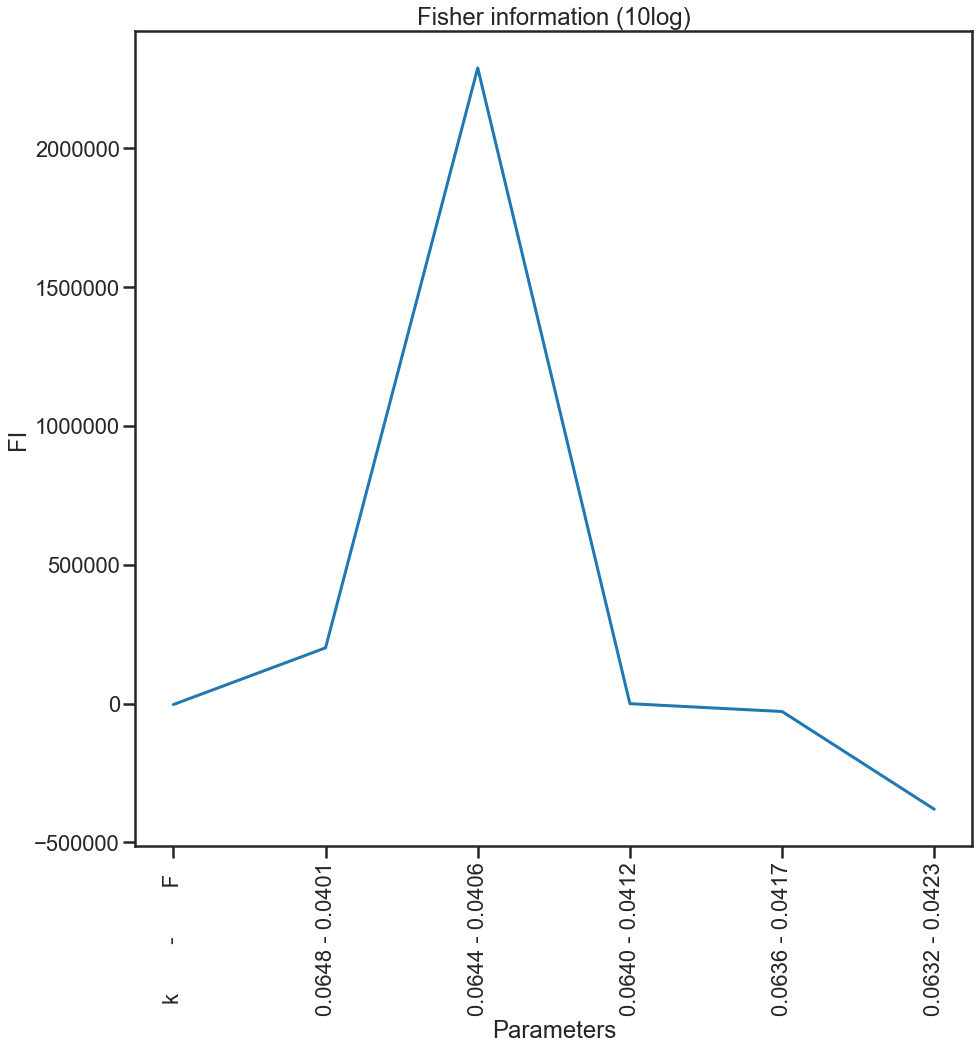

In [4]:
def gscott(n, F, k, T, Du=0.16, Dv=0.08, dt=1.0, dx=1.0):
    np.random.seed(seed=7) ## re-initialize seed to keep same initial conditions at each parameter setting
    U, V = np.zeros((n, n), dtype=np.float64), np.zeros((n, n), dtype=np.float64)
    r, m = n//40, n//2
    U[...] = 1.0
    V[m-r:m+r, m-r:m+r] = 0.25
    U[m-r:m+r, m-r:m+r] = 0.5
    U += np.random.normal(scale=0.05, size=U.shape)
    V += np.random.normal(scale=0.05, size=V.shape)
    return gray_scott(U, V, Du, Dv, F, k, dt, dx, T)

def fisher_information(inps,dk,df):
    p = []
    which = [(2,0),(1,1),(1,1),(0,2)]
    for i in inps:
        p.append(gaussian_kde(i))
    matrix = np.zeros(4)
    for i,k in zip(which,range(len(which))):
        matrix[k] = quad(lambda x: (((p[0].logpdf(x)-p[1].logpdf(x))/(2*dk))**i[0])*(((p[2].logpdf(x)-p[3].logpdf(x))/(2*df))**i[1])*p[4].pdf(x), -1000, 10000)[0]
    matrix = matrix.reshape((2,2)) ## Fisher matrix

    return matrix[0,0] + matrix[1,1] ## trace of fisher matrix


def bulk_fisher(f,k,dk,df, n = 100, T = 10000, rangesteps=3):
    iters = rangesteps
    
    fm, km = np.meshgrid(f, k)
#     print(fm)
    outp = np.zeros_like(fm)
    fis = []
    for index in tqdm(range(rangesteps), total=rangesteps):
        u, v = gscott(n, f[index], k[index], T)
        u1,v1 = gscott(n, f[index], k[index]+dk, T) ### All different points around point in parameter space
        u2,v2 = gscott(n, f[index], k[index]-dk, T)
        u3,v3 = gscott(n, f[index]+df, k[index], T)
        u4,v4 = gscott(n, f[index]-df, k[index], T)
        
        obj_u = calc_objects(u)
        obj_u1 = calc_objects(u1)
        obj_u2 = calc_objects(u2)
        obj_u3 = calc_objects(u3)
        obj_u4 = calc_objects(u4)
        
        if obj_u.any() and obj_u1.any() and obj_u2.any() and obj_u3.any() and obj_u4.any():
            inputs = [obj_u1,obj_u2,obj_u3,obj_u4,obj_u]
#             outp[index] = fisher_information(inputs,dk,df)
            pdfs_kde, bbox_kde = get_pdfs_from_data([obj_u, obj_u2, obj_u1, obj_u4, obj_u3], method="gaussian_kde")
            FIM_kde, int_err_kde = npfi(pdfs_kde, dk, N=n, bounds=bbox_kde, logarithmic=True)
            print(FIM_kde)
            fis.append(FIM_kde)
        else:
            fis.append(0)
            
    return outp, fis



f_min = 0.03
f_max = 0.042
k_min = 0.0621
k_max = 0.0631

dims = 4
rangesteps = 6 #20
# f = np.linspace(f_min,f_max,dims)
# k = np.linspace(k_min,k_max,dims)
k = np.linspace(0.0652, 0.0632, rangesteps)
f = np.linspace(0.0395, 0.04228, rangesteps)
df = (0.0652 - 0.0632) / rangesteps
dk = (0.0395 - 0.04228) / rangesteps

outp, fis = bulk_fisher(f, k,dk,df, 400, 35000, rangesteps)

ticklabels = ["{0:.4f} - {1:.4f}".format(k[i], f[i]) for i in range(rangesteps)]
ticklabels[0] = "k        -        F  "
plt.figure(figsize=(15,15))
plt.plot(fis)
plt.xticks(range(rangesteps), ticklabels, rotation='vertical')
plt.ylabel("FI")
plt.xlabel("Parameters")
plt.title("Fisher information (10log)")
plt.colorbar()
print(outp.T)
plt.show()